# Bank customers attrition analysis 

## Data

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, plot_confusion_matrix, auc
from sklearn.utils import shuffle
from sklearn.compose import make_column_transformer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [101]:
try:
    df = pd.read_csv('Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [102]:
display(df.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [104]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### Missing values

There are missing values in `tenure` variable.

In [105]:
pd.DataFrame(round(df.isna().mean()*100)).style.background_gradient('coolwarm')

,0
RowNumber,0.000000
CustomerId,0.000000
Surname,0.000000
CreditScore,0.000000
Geography,0.000000
Gender,0.000000
Age,0.000000
Tenure,9.000000
Balance,0.000000
NumOfProducts,0.000000


Tenure — for how many years a person has been a bank client. Let's fill in missing values with a random one between the maximum and minimum from the distribution of the `tenure`.

In [106]:
df['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [107]:
df.loc[df['Tenure'].isna(), 'Tenure'] = \
                   [randint(min(df['Tenure']), max(df['Tenure'])) for i in range(df['Tenure'].isna().sum())]

In [108]:
pd.DataFrame(round(df.isna().mean()*100)).style.background_gradient('coolwarm')

,0
RowNumber,0.000000
CustomerId,0.000000
Surname,0.000000
CreditScore,0.000000
Geography,0.000000
Gender,0.000000
Age,0.000000
Tenure,0.000000
Balance,0.000000
NumOfProducts,0.000000


### Duplicates

There is no duplicates in data.

In [109]:
df.duplicated().sum()

0

### Distribution of variables

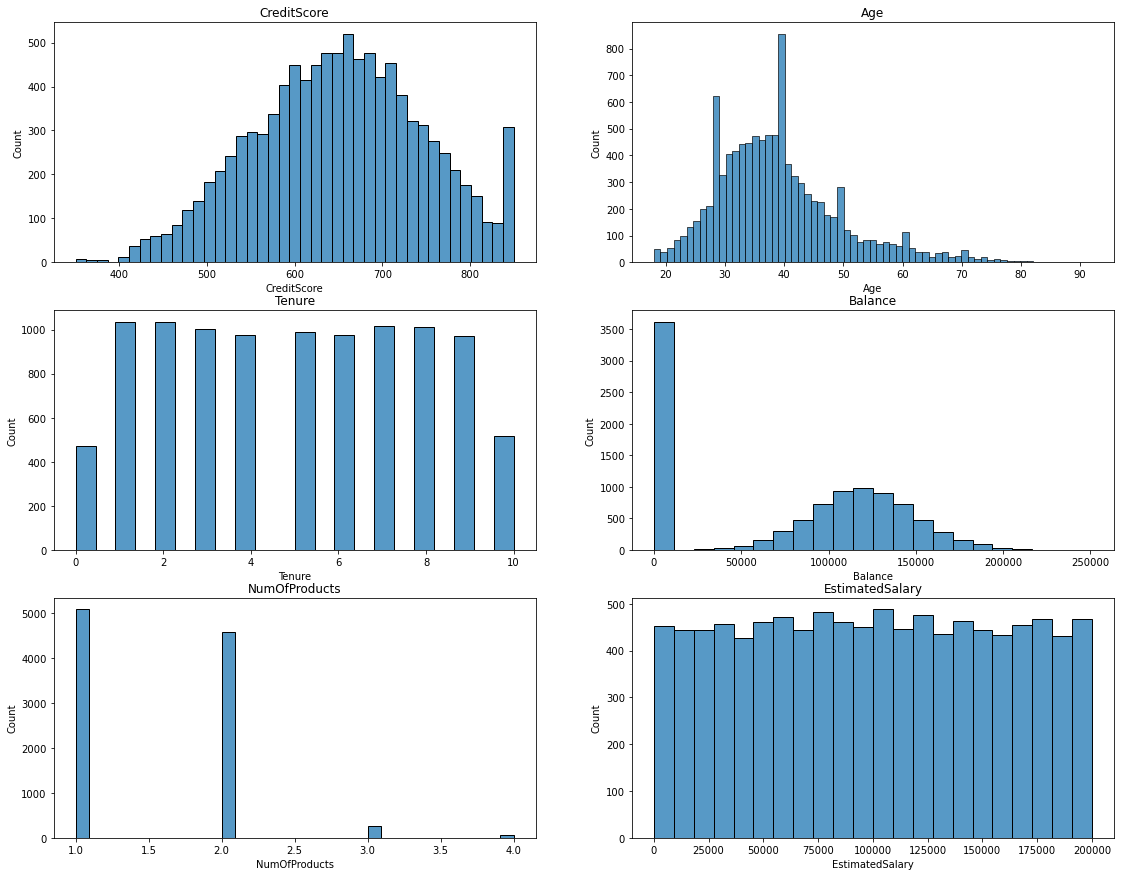

In [110]:
col_names = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
_, axs = plt.subplots(3, 2, figsize=(19,15))
axs = axs.ravel()

for i in range(len(col_names)):
    ax = axs[i]
    sns.histplot(ax=ax, x=df[col_names[i]], data=df)
    ax.tick_params(axis='x')
    ax.set_title(col_names[i])

There is outlier in the `Balance` variable - the balance on the account. Nevertheless, we will not drop it: it is quite possible that some people do not use their account, although they have one.

In [111]:
df['Balance'].value_counts()

0.00         3617
130170.82       2
105473.74       2
85304.27        1
159397.75       1
             ... 
81556.89        1
112687.69       1
108698.96       1
238387.56       1
130142.79       1
Name: Balance, Length: 6382, dtype: int64

Let's study categorical variables. On graph there is the median credit score in groups of women and men from different countries.

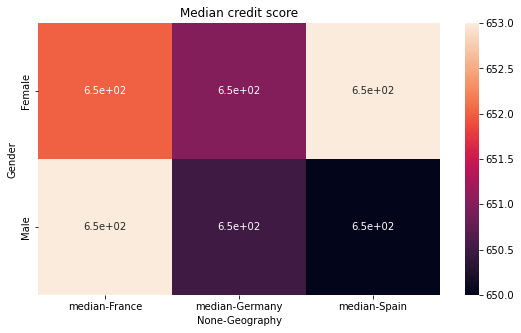

In [112]:
plt.figure(figsize=(9,5))
df_heatmap = df.pivot_table(values='CreditScore', index='Gender',columns='Geography', aggfunc={'median'})
sns.heatmap(df_heatmap,annot=True)
plt.title('Median credit score')
plt.show()

Next, let's look at target distribution.

In [113]:
print('Unique values of target variable:', df['Exited'].unique())

Unique values of target variable: [1 0]


There is an unequal distribution of target classes. When fitting models we need to take this problem into account.

In [114]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

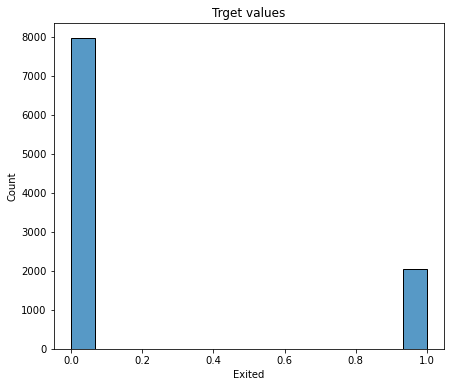

In [115]:
plt.figure(figsize=(7,6))
sns.histplot(x=df['Exited'], data=df)
plt.title('Trget values')
plt.show()

Finally, let's check data for multicollinearity. It can be seen from the scatterplots that the features are weakly correlated. Outlier at zero value in the `Balance` variable, which we decided to leave in the sample, also could be seen on the graph.

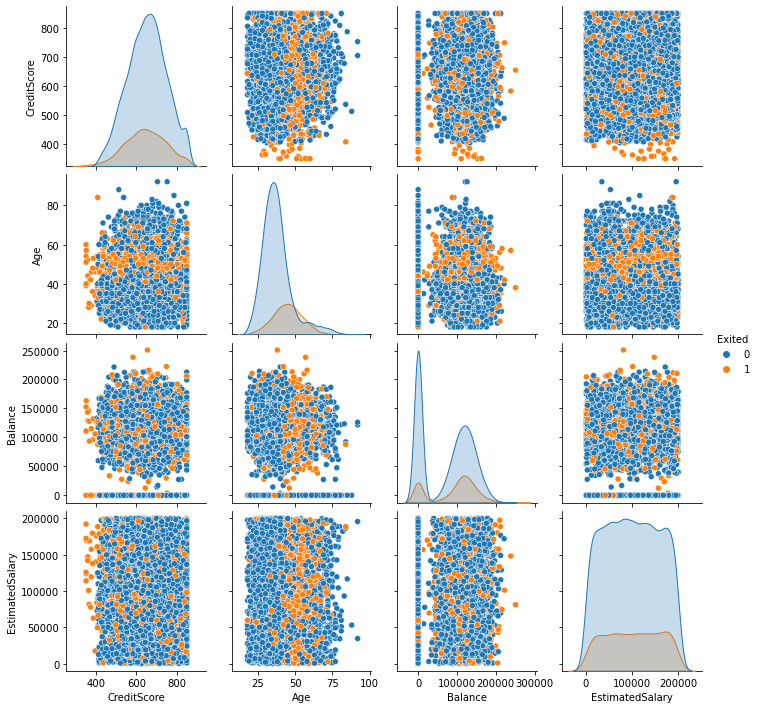

In [116]:
col_names = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']
sns.pairplot(df[col_names], hue='Exited')
plt.show()

**Summary:** After examining the data, we formulated the following tasks:
* Encode categorical variables (`Gender`, `Geography`)
* Get training, validation and test sets
* Scale quantitative variables
* Train models without accounting for imbalance
* Solve the problem of class imbalance (choose the best strategy)
* Train models considering imbalance, choose the best one (compare F1 score with AUR-ROC)
* Conduct final testing

Before starting data preprocessing, let's drop uninformative variables – `RowNumber`, `Surname`, `CustomerId`.

In [117]:
df = df.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## Data preprocessing

Let's use OHE strategy to encode ctegorical variables. Drop the first column.

In [118]:
df_ohe = pd.get_dummies(df, drop_first = True)
df_ohe.head() 

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Then we split the sample into training, validation and test in proportiom 3:1:1.

In [119]:
features = df_ohe.drop('Exited', axis=1)
target = df_ohe['Exited']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=42)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=42)

print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


We will use transformer in Logistic Regression pipeline to scale only numerical variables.

In [120]:
numerical = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
transformer = make_column_transformer((StandardScaler(), numerical), remainder='passthrough')

## Model fitting. Firs stage

Let's train the models without taking into account the imbalance. First, let's fit a Decision Tree Classifier, calculate the F1 score, plot the ROC curve and calculate AUC-ROC score.

In [121]:
model_tree = DecisionTreeClassifier(random_state=42)
model_tree.fit(features_train, target_train)

DecisionTreeClassifier(random_state=42)

In [122]:
predictions_valid = model_tree.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_tree.predict_proba(features_valid)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.464935064935065
AUC-ROC: 0.6704028589993504


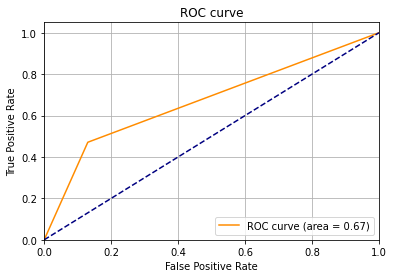

In [123]:
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Next let's fit Random Forest Classifier.

In [124]:
model_forest = RandomForestClassifier(random_state=42)
model_forest.fit(features_train, target_train)

RandomForestClassifier(random_state=42)

In [125]:
predictions_valid = model_forest.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_forest.predict_proba(features_valid)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.5540983606557377
AUC-ROC: 0.8275828460038986


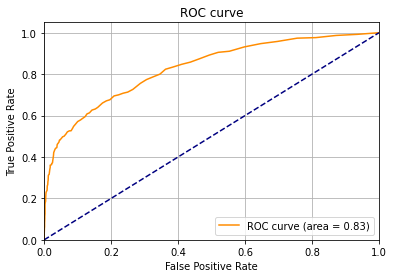

In [126]:
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Finally, results of classification with Logistic Regression:

In [127]:
model_log = Pipeline([('scaler', transformer),
                      ('linear_clf', LogisticRegression())])
model_log.fit(features_train, target_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary'])])),
                ('linear_clf', LogisticRegression())])

In [128]:
predictions_valid = model_log.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_log.predict_proba(features_valid)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.29942418426103645
AUC-ROC: 0.7535672514619884


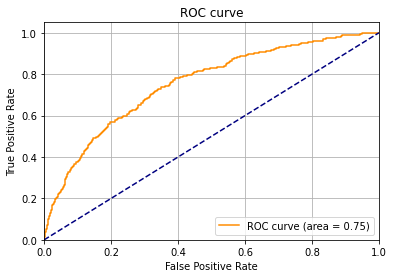

In [129]:
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Summary:** The F1 score for Logistic Regression is 0.3, AUC-ROC – 0.75. We observe better results for Random Forest Classifier – F1 = 0.56, AUC-ROC=0.83. Regarding Decision Tree Classifier, F1 score = 0.46, but AUC-ROC score is the lowest – 0.67. In general, the results are unsatisfactory. To improve it, we need to deal with data imbalance.

## Techniques to handle imbalanced data

In this section, we will compare techniques used to handle imbalanced data, including class weighting, upsampling and downsampling, and chose the best approach.

The majority of observations have target value equals to 0 - there are a lot of customers who did not leave the bank.

In [130]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

## Model fitting. Second stage

### Class weighting

Let's use `class_weight` parameter to automatically adjust weights inversely proportional to class frequencies in the input data.

In [131]:
model_tree_weighted = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model_tree_weighted.fit(features_train, target_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [132]:
predictions_valid = model_tree_weighted.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_tree_weighted.predict_proba(features_valid.values)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.45298013245033114
AUC-ROC: 0.6620370370370371


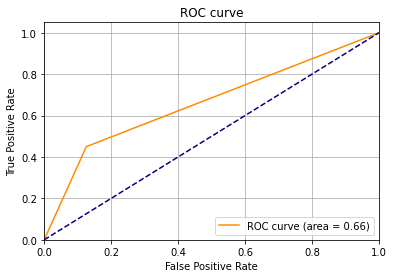

In [133]:
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [134]:
model_forest_weighted = RandomForestClassifier(random_state=42, class_weight='balanced')
model_forest_weighted.fit(features_train, target_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [135]:
predictions_valid = model_forest_weighted.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_forest_weighted.predict_proba(features_valid.values)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.5414551607445008
AUC-ROC: 0.8259478557504873


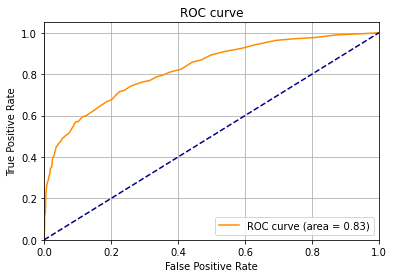

In [136]:
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [137]:
model_log_weighted = Pipeline([('scaler', transformer),
                               ('linear_clf', LogisticRegression(class_weight='balanced'))])

model_log_weighted.fit(features_train, target_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary'])])),
                ('linear_clf', LogisticRegression(class_weight='balanced'))])

In [138]:
predictions_valid = model_log_weighted.predict(features_valid)
print('F1 score:', f1_score(target_valid, predictions_valid))

proba_valid = model_log_weighted.predict_proba(features_valid)[:,1]
print('AUC-ROC:', roc_auc_score(target_valid, proba_valid))

F1 score: 0.46221441124780316
AUC-ROC: 0.7542235217673814


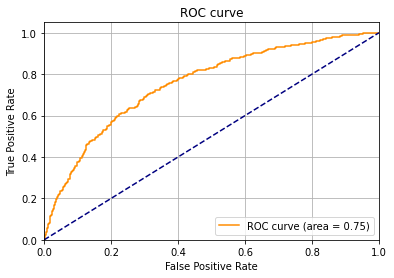

In [139]:
fpr, tpr, treshold = roc_curve(target_valid, proba_valid)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Summary:** Although Linear Regression F1 score has risen from 0.3 to 0.46, AUC-ROC score remained unchanged. In addition, the validation F1 score has slightly dropped for Random Forest Classifiers and hasn't changed for Decision Tree. Therefore, it is better to consider other teqniques for dealing with data imbalance.

## Model fitting. Third stage

### Upsampling

In [140]:
# re-split the sample into train and test

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=42)

The next approach is an upsampling. We need to upsample those who left the bank (class 1). 

We can use Synthetic Minority Oversampling Technique (SMOTE) for upsampling – it doesn't copy objects from the sample, but generate them synthetically.

In [144]:
%%time

params = {'tree_clf__max_depth': range(1,13,2),
          'tree_clf__min_samples_leaf': range(1,8),
          'tree_clf__min_samples_split': range(2,10,2)
         }

pipe_tree = Pipeline([('smote', SMOTE(random_state=42)), 
                      ('tree_clf', DecisionTreeClassifier(random_state=42))])

grid_tree = GridSearchCV(pipe_tree, params, cv=KFold(n_splits=5))
grid_tree.fit(features_train, target_train)

CPU times: user 28.8 s, sys: 206 ms, total: 29 s
Wall time: 29 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('tree_clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'tree_clf__max_depth': range(1, 13, 2),
                         'tree_clf__min_samples_leaf': range(1, 8),
                         'tree_clf__min_samples_split': range(2, 10, 2)})

In [145]:
f1 = np.mean(cross_val_score(grid_tree.best_estimator_, features_train, target_train, scoring='f1'))
print('F1 score:', f1)

F1 score: 0.534761978240458


In [146]:
proba_train = grid_tree.predict_proba(features_train)[:,1]
print('AUC-ROC:', roc_auc_score(target_train, proba_train))

AUC-ROC: 0.8614611939511012


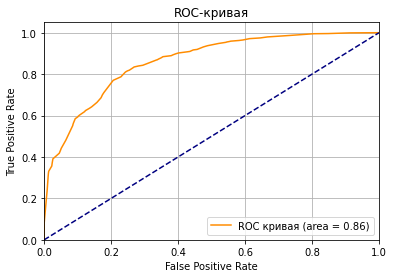

In [147]:
fpr, tpr, treshold = roc_curve(target_train, proba_train)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Let's use SMOTE approach for Random Forest Classifier.

In [148]:
%%time

pipe_forest = Pipeline([('smote', SMOTE(random_state=42)), 
                        ('forest_clf', RandomForestClassifier(random_state=42))])

params = {'forest_clf__max_depth': range(10, 30,2),
          'forest_clf__n_estimators': range(30, 60, 5)}

grid_forest = GridSearchCV(pipe_forest, params, cv=KFold(n_splits=5))
grid_forest.fit(features_train, target_train)

CPU times: user 2min 11s, sys: 618 ms, total: 2min 12s
Wall time: 2min 12s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('forest_clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'forest_clf__max_depth': range(10, 30, 2),
                         'forest_clf__n_estimators': range(30, 60, 5)})

In [149]:
f1 = np.mean(cross_val_score(grid_forest.best_estimator_, features_train, target_train, scoring='f1'))
print('F1 score:', f1)

F1 score: 0.5735722182016034


In [150]:
proba_train = grid_forest.predict_proba(features_train)[:,1]
print('AUC-ROC:', roc_auc_score(target_train, proba_train))

AUC-ROC: 0.9994903073881866


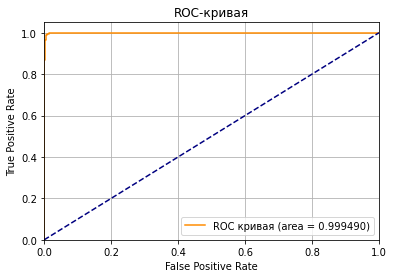

In [151]:
fpr, tpr, treshold = roc_curve(target_train, proba_train)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Regarding Random Forest Classifier, area under ROC curve and F1 score has rapidly improved.

Let's fit Logistic Regression.

In [153]:
%%time

pipe_linear = Pipeline([('smote', SMOTE(random_state=42)),
                        ('scaler', transformer),
                        ('linear_clf', LogisticRegression())])

pipe_linear.fit(features_train, target_train)

CPU times: user 93.6 ms, sys: 30.1 ms, total: 124 ms
Wall time: 42.8 ms


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary'])])),
                ('linear_clf', LogisticRegression())])

In [155]:
f1 = np.mean(cross_val_score(pipe_linear, features_train, target_train, scoring='f1'))
print('F1 score:', f1)

F1 score: 0.4575122559209926


In [156]:
proba_train = pipe_linear.predict_proba(features_train)[:,1]
print('AUC-ROC:', roc_auc_score(target_train, proba_train))

AUC-ROC: 0.7325811055838917


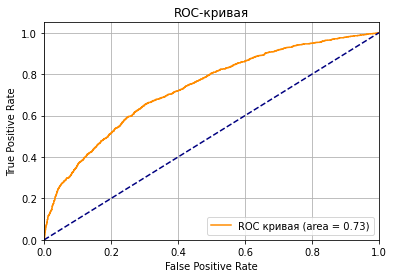

In [157]:
fpr, tpr, treshold = roc_curve(target_train, proba_train)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

As a result, area under ROC-curve and F1 score has dropped slightly.

**Summary:** F1 score of Decision Tree Classifier has improved from 0.45 to 0.53, AUC-ROC score has also improved from 0.66 to 0.86. F1 score of the Logistic Regression has dropped from 0.462 to 0.457 as well as the area under the ROC curve decreased slightly from 0.75 to 0.73. Random Forest F-score has changed from 0.54 to 0.57, the area under the ROC-curve has changed from 0.82 to 0.99[9].

Random forest is still the best model.

## Model fitting. Fourth stage

### Downsampling

An alternative approach is to remove some of the observations from the largest class – downsampling. In our case, the largest class is those who did not leave the bank.

For example, Random Under Sampler that reduces observations by randomly selecting it so that the resulting sample ratio is 1:1 (`sampling_strategy=0.5`).

In [158]:
pipe_tree_down = Pipeline([('RUS', RandomUnderSampler(random_state=42, sampling_strategy=0.5)), 
                           ('tree_clf', DecisionTreeClassifier(random_state=42))])

params = {'tree_clf__max_depth': range(1,13,2),
          'tree_clf__min_samples_leaf': range(1,8),
          'tree_clf__min_samples_split': range(2,10,2)
         }

grid_tree_down = GridSearchCV(pipe_tree_down, params, cv=KFold(n_splits=5))
grid_tree_down.fit(features_train, target_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('RUS',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('tree_clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'tree_clf__max_depth': range(1, 13, 2),
                         'tree_clf__min_samples_leaf': range(1, 8),
                         'tree_clf__min_samples_split': range(2, 10, 2)})

In [159]:
f1 = np.mean(cross_val_score(grid_tree_down.best_estimator_, features_train, target_train, scoring='f1'))
print('F1 score:', f1)

F1 score: 0.5173138364006159


In [160]:
proba_train = grid_tree_down.predict_proba(features_train)[:,1]
print('AUC-ROC:', roc_auc_score(target_train, proba_train))

AUC-ROC: 0.7953450977559694


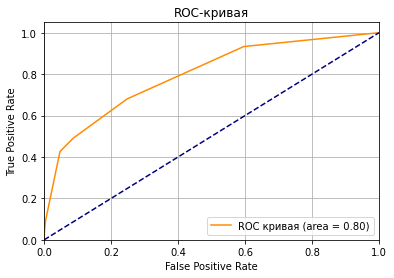

In [161]:
fpr, tpr, treshold = roc_curve(target_train, proba_train)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Let's use `RandomUnderSampler()` for Random Forest Classifier.

In [162]:
%%time

pipe_forest_down = Pipeline([('RUS', RandomUnderSampler(random_state=42, sampling_strategy=0.5)), 
                             ('forest_clf', RandomForestClassifier(random_state=42))])

params = {'forest_clf__max_depth': range(1,13,2),
          'forest_clf__n_estimators': range(10, 30, 10)}

grid_forest_down = GridSearchCV(pipe_forest_down, params, cv=KFold(n_splits=5))
grid_forest_down.fit(features_train, target_train)

CPU times: user 3.22 s, sys: 30 ms, total: 3.25 s
Wall time: 3.25 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('RUS',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('forest_clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'forest_clf__max_depth': range(1, 13, 2),
                         'forest_clf__n_estimators': range(10, 30, 10)})

In [163]:
f1 = np.mean(cross_val_score(grid_forest_down.best_estimator_, features_train, target_train, scoring='f1'))
print('F1 score:', f1)

F1 score: 0.6096371978015644


In [164]:
proba_train = grid_forest_down.predict_proba(features_train)[:,1]
print('AUC-ROC:', roc_auc_score(target_train, proba_train))

AUC-ROC: 0.8931995906749987


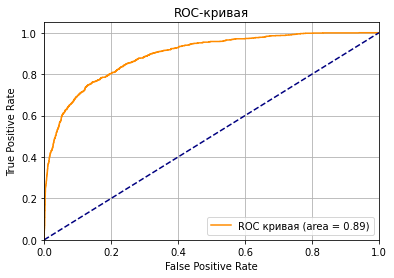

In [165]:
fpr, tpr, treshold = roc_curve(target_train, proba_train)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

For Random Forest Classifier, `RandomUnderSampler` technique shows the best result – maximum of all obtained.

Let's fit Logistic Regression.

In [166]:
%%time

pipe_linear = Pipeline([('RUS', RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                        ('scaler', transformer),
                        ('linear_clf', LogisticRegression())])

pipe_linear.fit(features_train, target_train)

CPU times: user 63.9 ms, sys: 20.8 ms, total: 84.6 ms
Wall time: 33.4 ms


Pipeline(steps=[('RUS',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary'])])),
                ('linear_clf', LogisticRegression())])

In [167]:
f1 = np.mean(cross_val_score(pipe_linear, features_train, target_train, scoring='f1'))
print('F1 score:', f1)

F1 score: 0.4653244495548171


In [168]:
proba_train = pipe_linear.predict_proba(features_train)[:,1]
print('AUC-ROC:', roc_auc_score(target_train, proba_train))

AUC-ROC: 0.7692478968990029


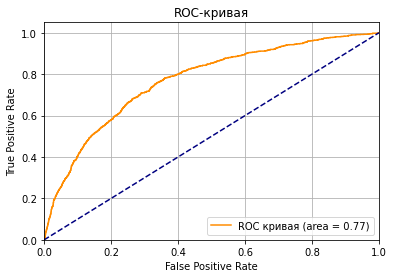

In [169]:
fpr, tpr, treshold = roc_curve(target_train, proba_train)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Summary:** Quality of Logistic Regression and Random Forest Classifier has improved while quality of Decision Tree Classifier – decreased. At this stage, Random Forest Classifier is still the best model.

## Model fitting. Fifth stage

### Combination of two approaches

At this stage, Random Forest Classifier copes best with classification and taking into account the imbalance of classes. We tried two strategies to deal with imbalance - upsampling and downsampling. We used different approaches for implementing them both manually and using built-in libraries. In some [articles](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) it was suggested to combine upsampling and downsampling. Let's try to implement this approach.

In [170]:
over = SMOTE(random_state=42)
under = RandomUnderSampler(random_state=42)
clf = RandomForestClassifier(random_state=42)
steps = [('over', over), ('under', under), ('forest_clf', clf)]
pipeline_combo = Pipeline(steps=steps)

In [171]:
params = {'forest_clf__max_depth': range(10,30,2),
          'forest_clf__n_estimators': range(30, 60, 5)}

grid_forest_combo = GridSearchCV(pipeline_combo, params, cv=KFold(n_splits=5))

grid_forest_combo.fit(features_train, target_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('over', SMOTE(random_state=42)),
                                       ('under',
                                        RandomUnderSampler(random_state=42)),
                                       ('forest_clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'forest_clf__max_depth': range(10, 30, 2),
                         'forest_clf__n_estimators': range(30, 60, 5)})

In [172]:
f1 = np.mean(cross_val_score(grid_forest_combo.best_estimator_, features_train, target_train, scoring='f1'))
print('F1 score:', f1)

F1 score: 0.5663023631610938


In [173]:
proba_train = grid_forest_combo.predict_proba(features_train)[:,1]
print('AUC-ROC:', roc_auc_score(target_train, proba_train))

AUC-ROC: 0.9999994023704719


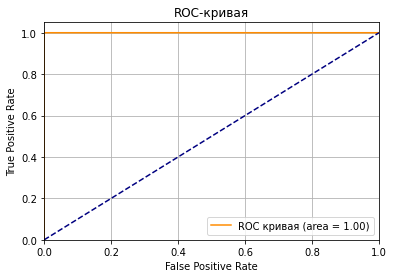

In [174]:
fpr, tpr, treshold = roc_curve(target_train, proba_train)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Summary:** F1 and AUC-ROC scores has decreased. 

## Model testing

In [177]:
predictions_test = grid_forest_down.predict(features_test)
print('F1 score:', f1_score(target_test, predictions_test))

proba_test = grid_forest_down.predict_proba(features_test)[:,1]
print('AUC-ROC:', roc_auc_score(target_test, proba_test))

F1 score: 0.6034712950600801
AUC-ROC: 0.8495377143078293


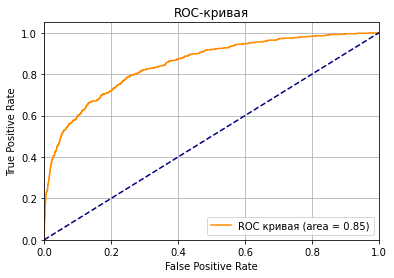

In [178]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, proba_test)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Summary:** To sum up, simce the downsampling technique (RandomUnderSampler) showed the highest result, it is proposed to use it. In addition, since the highest quality showd Random Forest Classifier we will use this model to predict customers attrition. Final metrics are F1 score: 0.60, AUC-ROC: 0.85.

## Conclusion

In this study, we examined and prepared the data. Since data is imbalanced we used several tecniques to handle it. As the result, we stopped at downsampling (RandomUnderSampler) in this research. As a result, we got F score = 0.60 on the test set and AUC-ROC score = 0.85, which also indicates a good model. Thus, we have chosen the best model to predict whether a client will leave the bank or not. Random Forest Classifie has shown the best quality metrics, so it is proposed to use this model to solve the task.